# Data preprocessing

## Imports and helper functions

In [28]:
import imgaug as ia
import imgaug.augmenters as iaa
import skimage.io as io
import os
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import skimage.io as ioimage_stack
import glob
import uuid

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image
from tqdm import tqdm


AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir = "../../../datasets/original"
augmented_data_dir = "../../../datasets/original/augmented_dataset"
CLASS_NAMES = os.listdir(data_dir)
dirs = [data_dir + "/" + c for c in CLASS_NAMES ]

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224


def to_jpg_from(dateset_dir, classes, from_extension="jfif"):
    for cl in classes:
        for file in tqdm(glob.glob(f"{dateset_dir}/{cl}/*.{from_extension}")):
            im = Image.open(file)
            rgb_im = im.convert('RGB')
            rgb_im.save(file.replace("."+from_extension, "_" + str(uuid.uuid4()) + ".jpg"), quality=100)


def rename_files(dateset_dir, classes, extension="jpg"):
    for cl in classes:
        for i, file in tqdm(enumerate(glob.glob(f"{dateset_dir}/{cl}/*.{extension}"))):
            num = str(i).rjust(6, "0")
            cl_name = cl.replace(" ", "")
            os.rename(file, f"{dateset_dir}/{cl}/{cl_name}_{num}.{extension}")
            
    
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
        
        
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

FileNotFoundError: [Errno 2] No such file or directory: '../../../datasets/original'

## Unify extensions

In [2]:
to_jpg_from(data_dir, CLASS_NAMES, from_extension="png")

100%|██████████| 284/284 [00:00<00:00, 293.85it/s]


## Unify filenames

In [3]:
rename_files(data_dir, CLASS_NAMES)

14051it [00:00, 76462.80it/s]
5950it [00:00, 85223.01it/s]


## Train, Test and Validation split

In [4]:
class_images = {}

for cl, data_path in zip(CLASS_NAMES, dirs):
    class_images[cl] = np.array(io.collection.glob(data_path + "/*.jpg"))

counts = [len(value) for key, value in class_images.items()]
min_count = min(counts)

from sklearn.model_selection import train_test_split
sets = {}
for key, value in class_images.items():
    X = value
    y = [key for item in value]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1755, random_state=1)
        
    sets[key + "_train"] = X_train
    sets[key + "_test"] = X_test
    sets[key + "_val"] = X_val

In [5]:
for key, value in sets.items():
    print(key, "->", len(value))

other_train -> 9847
other_test -> 2108
other_val -> 2096
acros_train -> 4169
acros_test -> 893
acros_val -> 888


## Move files to train, test and val dirs

In [9]:
output_dir = "../../../datasets/train_ready_dataset"

set_folders = ["train", "test", "val"]

# make sure that dirs exist

try:
    os.mkdir(output_dir)
except Exception:
    print(f"'{output_dir}' already exists")

for set_folder in set_folders:
    p = f"{output_dir}/{set_folder}"
    try:
        os.mkdir(p)
    except Exception:
        print(f"'{p}' already exists")
    for cl in CLASS_NAMES:
        p = f"{output_dir}/{set_folder}/{cl}"
        try:
            os.mkdir(p)
        except Exception:
            print(f"'{p}' already exists")

In [10]:
from shutil import copy
dest_path_base = "../../../datasets/train_ready_dataset"


for key, value in sets.items():
    splitted = key.split("_")
    cl = splitted[0]
    set_folder = splitted[1]
    
    for file_path in tqdm(value):
        file_name = file_path.split("\\")[-1]
        copy(file_path, f"{dest_path_base}/{set_folder}/{cl}")

100%|██████████| 888/888 [00:00<00:00, 8870.79it/s]


## Check dateset sizes

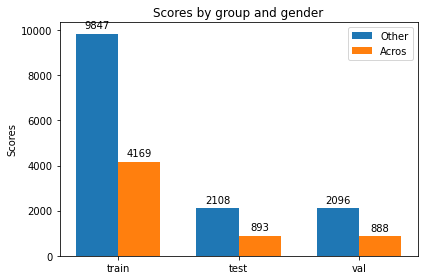

In [27]:
dict = {}
for c in CLASS_NAMES:
    dict[c] = []

for key, value in sets.items():
    arr = key.split("_")
    dict[arr[0]].append(len(value))

x = np.arange(len(set_folders))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dict['other'], width, label='Other')
rects2 = ax.bar(x + width/2, dict['acros'], width, label='Acros')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(set_folders)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()